# Project 4 - WEST NILE VIRUS

The first markdown cell in a notebook is a great place to provide an overview of your entire project. You will likely want to at least state your

## Problem Statement

## Executive Summary

If you want to, it's great to use relative links to direct your audience to various sections of a notebook. **HERE'S A DEMONSTRATION WITH THE CURRENT SECTION HEADERS**:

### Contents:
- [2017 Data Import & Cleaning](#Data-Import-and-Cleaning)
- [2018 Data Import and Cleaning](#2018-Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Visualize-the-data)
- [Descriptive and Inferential Statistics](#Descriptive-and-Inferential-Statistics)
- [Outside Research](#Outside-Research)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

**If you combine your problem statement, executive summary, data dictionary, and conclusions/recommendations, you have an amazing README.md file that quickly aligns your audience to the contents of your project.** Don't forget to cite your data sources!

*All libraries used should be added here*

In [2]:
#import libraries
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Data Import and Cleaning

In [3]:
#import data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')

In [3]:
# convert to date format
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
# fill missing values in Station 2 with value from Station 1
# fill missing values in Station 2 with value from Station 
cols = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Depth',
        'SeaLevel', 'AvgSpeed']
for col in cols:
    if weather[col].dtypes == 'object':
        for k, v in enumerate(weather[col]):
            if v == 'M' and weather.iloc[k]['Station'] == 1:
                weather.loc[k,col] = weather[col][k+1]
            if v == 'M' and weather.iloc[k]['Station'] == 2:
                weather.loc[k,col] = weather[col][k-1]
        weather[col] = pd.to_numeric(weather[col])
        
weather = weather.drop(["Sunrise", "Sunset", "CodeSum","Water1","SnowFall","PrecipTotal","StnPressure"], axis=1)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [5]:
#del variables that are not useful
#address related are deleted as location is determined by Latitude and Longuitude
#checked online all species are relevant for WNV
def del_var(data):
    try:
        del data['Address']
        del data['Block']
        del data['Street']
        del data['AddressNumberAndStreet']
        del data['AddressAccuracy']
        del data['Species']
    except:
        pass

In [6]:
del_var(train)

In [7]:
del_var(test)

In [8]:
def aggregate_train (data):
    grouped = data.groupby(['Date', 'Trap', 'Latitude', 'Longitude'])
    aggregated = pd.DataFrame(grouped.agg({'NumMosquitos': np.sum, 'WnvPresent': np.max})).reset_index()
    aggregated.sort_values(by='NumMosquitos', ascending = False)
    aggregated.sort_values(by='Date', inplace=True)
    aggregated = aggregated.reset_index(drop = True)
  #  aggregated['Month'] = aggregated.Date.month
  #  aggregated['Year'] = aggregated.Date.year
    return aggregated

In [9]:
agg_train = aggregate_train(train)

In [10]:
agg_train.head()

,Date,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,T002,41.954690,-87.800991,2,0
1,2007-05-29,T159,41.732984,-87.649642,1,0
2,2007-05-29,T153,41.907645,-87.760886,1,0
3,2007-05-29,T148,42.017430,-87.687769,1,0
4,2007-05-29,T143,41.999129,-87.795585,1,0


In [11]:
agg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 6 columns):
Date            4616 non-null object
Trap            4616 non-null object
Latitude        4616 non-null float64
Longitude       4616 non-null float64
NumMosquitos    4616 non-null int64
WnvPresent      4616 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 216.5+ KB


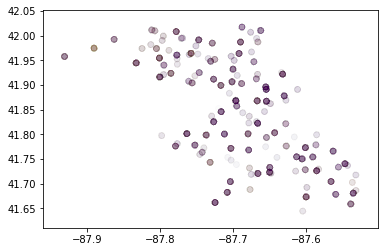

In [12]:
# look at dispersion of virus incidence geographically
plt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.WnvPresent, alpha = .01)

In [13]:
import math
# source: https://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [14]:
# weather stations 1 and 2 lat/longitude
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
station_1_lat = 41.995
station_1_lon = -87.933
station_2_lat = 41.786
station_2_lon = -87.752
# function to calculate whether station 1 or 2 (from weather.csv) is closer
def closest_station(lat, lon):
    if (distance_on_unit_sphere(lat, lon, station_1_lat, station_1_lon) <
        distance_on_unit_sphere(lat, lon, station_2_lat, station_2_lon)):
        return 1
    else: return 2
    
#source: Data Description
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [15]:
# add station to indicate whether station 1 or 2 is closer
#create unique variable to combine train and weather data
def station_var (data):
    data['Station'] = [closest_station(a,b) for (a, b) in zip(data.Latitude, data.Longitude)]
    data['unique'] =  data['Station'].astype(str) + str(": ") + data['Date'].astype(str)

In [16]:
station_var(agg_train)
station_var(test)

In [17]:
#create unique variable to combine train and weather data
weather['unique'] =  weather['Station'].astype(str) + str(": ") + weather['Date'].astype(str)

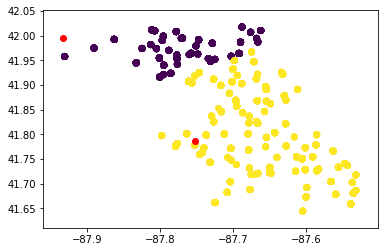

In [18]:
# look at dispersion of traps geographically
plt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.Station)
plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c = 'r')
plt.show()

In [19]:
combined_train = pd.merge (agg_train, weather, how="inner", on="unique")
combined_test = pd.merge (test, weather, how="inner", on="unique")

In [20]:
combined_train = combined_train.drop(["Date_y", "Station_x", "unique"], axis=1)
combined_test = combined_test.drop(["Date_y", "Station_x", "unique"], axis=1)

In [21]:
combined_train 

,Date_x,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Station_y,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Depth,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,T002,41.954690,-87.800991,2,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
1,2007-05-29,T148,42.017430,-87.687769,1,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
2,2007-05-29,T143,41.999129,-87.795585,1,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
3,2007-05-29,T015,41.974089,-87.824812,5,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
4,2007-05-29,T007,41.994991,-87.769279,1,0,1,88,60,74,10,58,65,0,9,0,30.11,5.8,18,6.5
5,2007-05-29,T159,41.732984,-87.649642,1,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4
6,2007-05-29,T153,41.907645,-87.760886,1,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4
7,2007-05-29,T129,41.891126,-87.611560,3,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4
8,2007-05-29,T094,41.720848,-87.666014,3,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4
9,2007-05-29,T091,41.862292,-87.648860,1,0,2,88,65,77,10,59,66,0,12,0,30.09,5.8,16,7.4


## Baseline

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, linear_model, datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns



plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [23]:
X = combined_train.drop(["Latitude", "Longitude", "WnvPresent","Trap","Date_x"], axis=1)
y = combined_train.WnvPresent

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [25]:
class model_evaluation:
   
    def __init__(self, y_test, predicted_value):
        self.y_test = y_test
        self.predicted_value = predicted_value
        
    def confusion_matrix (self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.predicted_value).ravel()
        print("True Negatives: %s" % tn)
        print("False Positives: %s" % fp)
        print("False Negatives: %s" % fn)
        print("True Positives: %s" % tp)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print("Precision: {}" .format (tp/(tp+fp)))
        print("Recall: {}" .format (tp/(tp+fn)))
        F1_score = 2*((precision*recall)/(precision+recall))
        print ("F1 score: {}" .format(2*((precision*recall)/(precision+recall))))
        self.score = F1_score

In [26]:
lr_model = LogisticRegression()

In [27]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test,predicted_lr)
lrg.confusion_matrix ()

True Negatives: 1054
False Positives: 2
False Negatives: 90
True Positives: 8
Precision: 0.8
Recall: 0.08163265306122448
F1 score: 0.1481481481481481


C:\Users\Serene\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
